## Time Series Modeling

In this notebook, we will go through the basics of time series modeling. We start by exploring the building blocks of time series and how to separate them using some decomposition methods. Later, we will introduce the concept of stationarity and why it is important, how to test for it, and ultimately how to achieve it in case the original series is not stationary.
We will also look into the most widely used approach to time series modeling — ARIMA class models.
We cover the following :
- Decomposing time series
- Correcting for stationarity in time series
- Modeling time series with ARIMA class models 
- Forecasting using ARIMA class models

### Importing Libraries and Dataset

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
#plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = (24, 18)
plt.rcParams['figure.dpi'] = 300

import datetime 
from datetime import date
import scipy.stats as scs
import statsmodels.api as sm
from math import sqrt
#from math import log
from scipy import stats
from scipy.stats import boxcox

from statsmodels.tsa.seasonal import seasonal_decompose

#STL function
from statsmodels.tsa.seasonal import STL
#Arima model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm
from sklearn.metrics import mean_squared_error


#pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Let's get prices for Apple stock 
start_date = datetime.datetime(2015,1,1) 
end_date = datetime.datetime(2022,5,31) 
df = yf.download("AAPL", start=start_date, end=end_date, adjusted=True, progress=False) 
df = df.resample('W').last().rename(columns={'Adj Close': 'prices'}).prices #change frequency to weekly
dataset = pd.DataFrame(df)
dataset.head()

prices
Date                 
2015-01-04  24.644018
2015-01-11  25.248114
2015-01-18  23.891148
2015-01-25  25.466763
2015-02-01  26.408978

## Decomposing time series

Time series decomposition refers to the method by which we reduce our time series data into its following four components:

- Trend [T] - The trend of a time series refers to the general direction in which the time series is moving. Time series can have a positive or a negative trend, but can also have no trend.
- Cycle [C] - The cycle for time series data refers to its tendency to rise and fall at inconsistent frequencies. We often use the cycle component of a time series to discuss business cycles in economic data.
- Seasonality [S] - The seasonal component of a time series is similar to its cycle component except for one important difference: the seasonal component refers to data that rises and falls at consistent frequencies.
- Remainder [R] - The remainder is what’s left of the time series data after removing its trend, cycle, and seasonal components. It is the random fluctuation in the time series data that the above components cannot explain.


When forecasting, it is advantageous to use a ‘seasonally-adjusted’ time series, which is just a time series with the seasonal component removed. This allows a forecaster to focus on predicting the general trend of the data.

A second reason to use time series decomposition is to identify any interesting behavior in the seasonal component. Then, we can research why our data moves in the way it does.

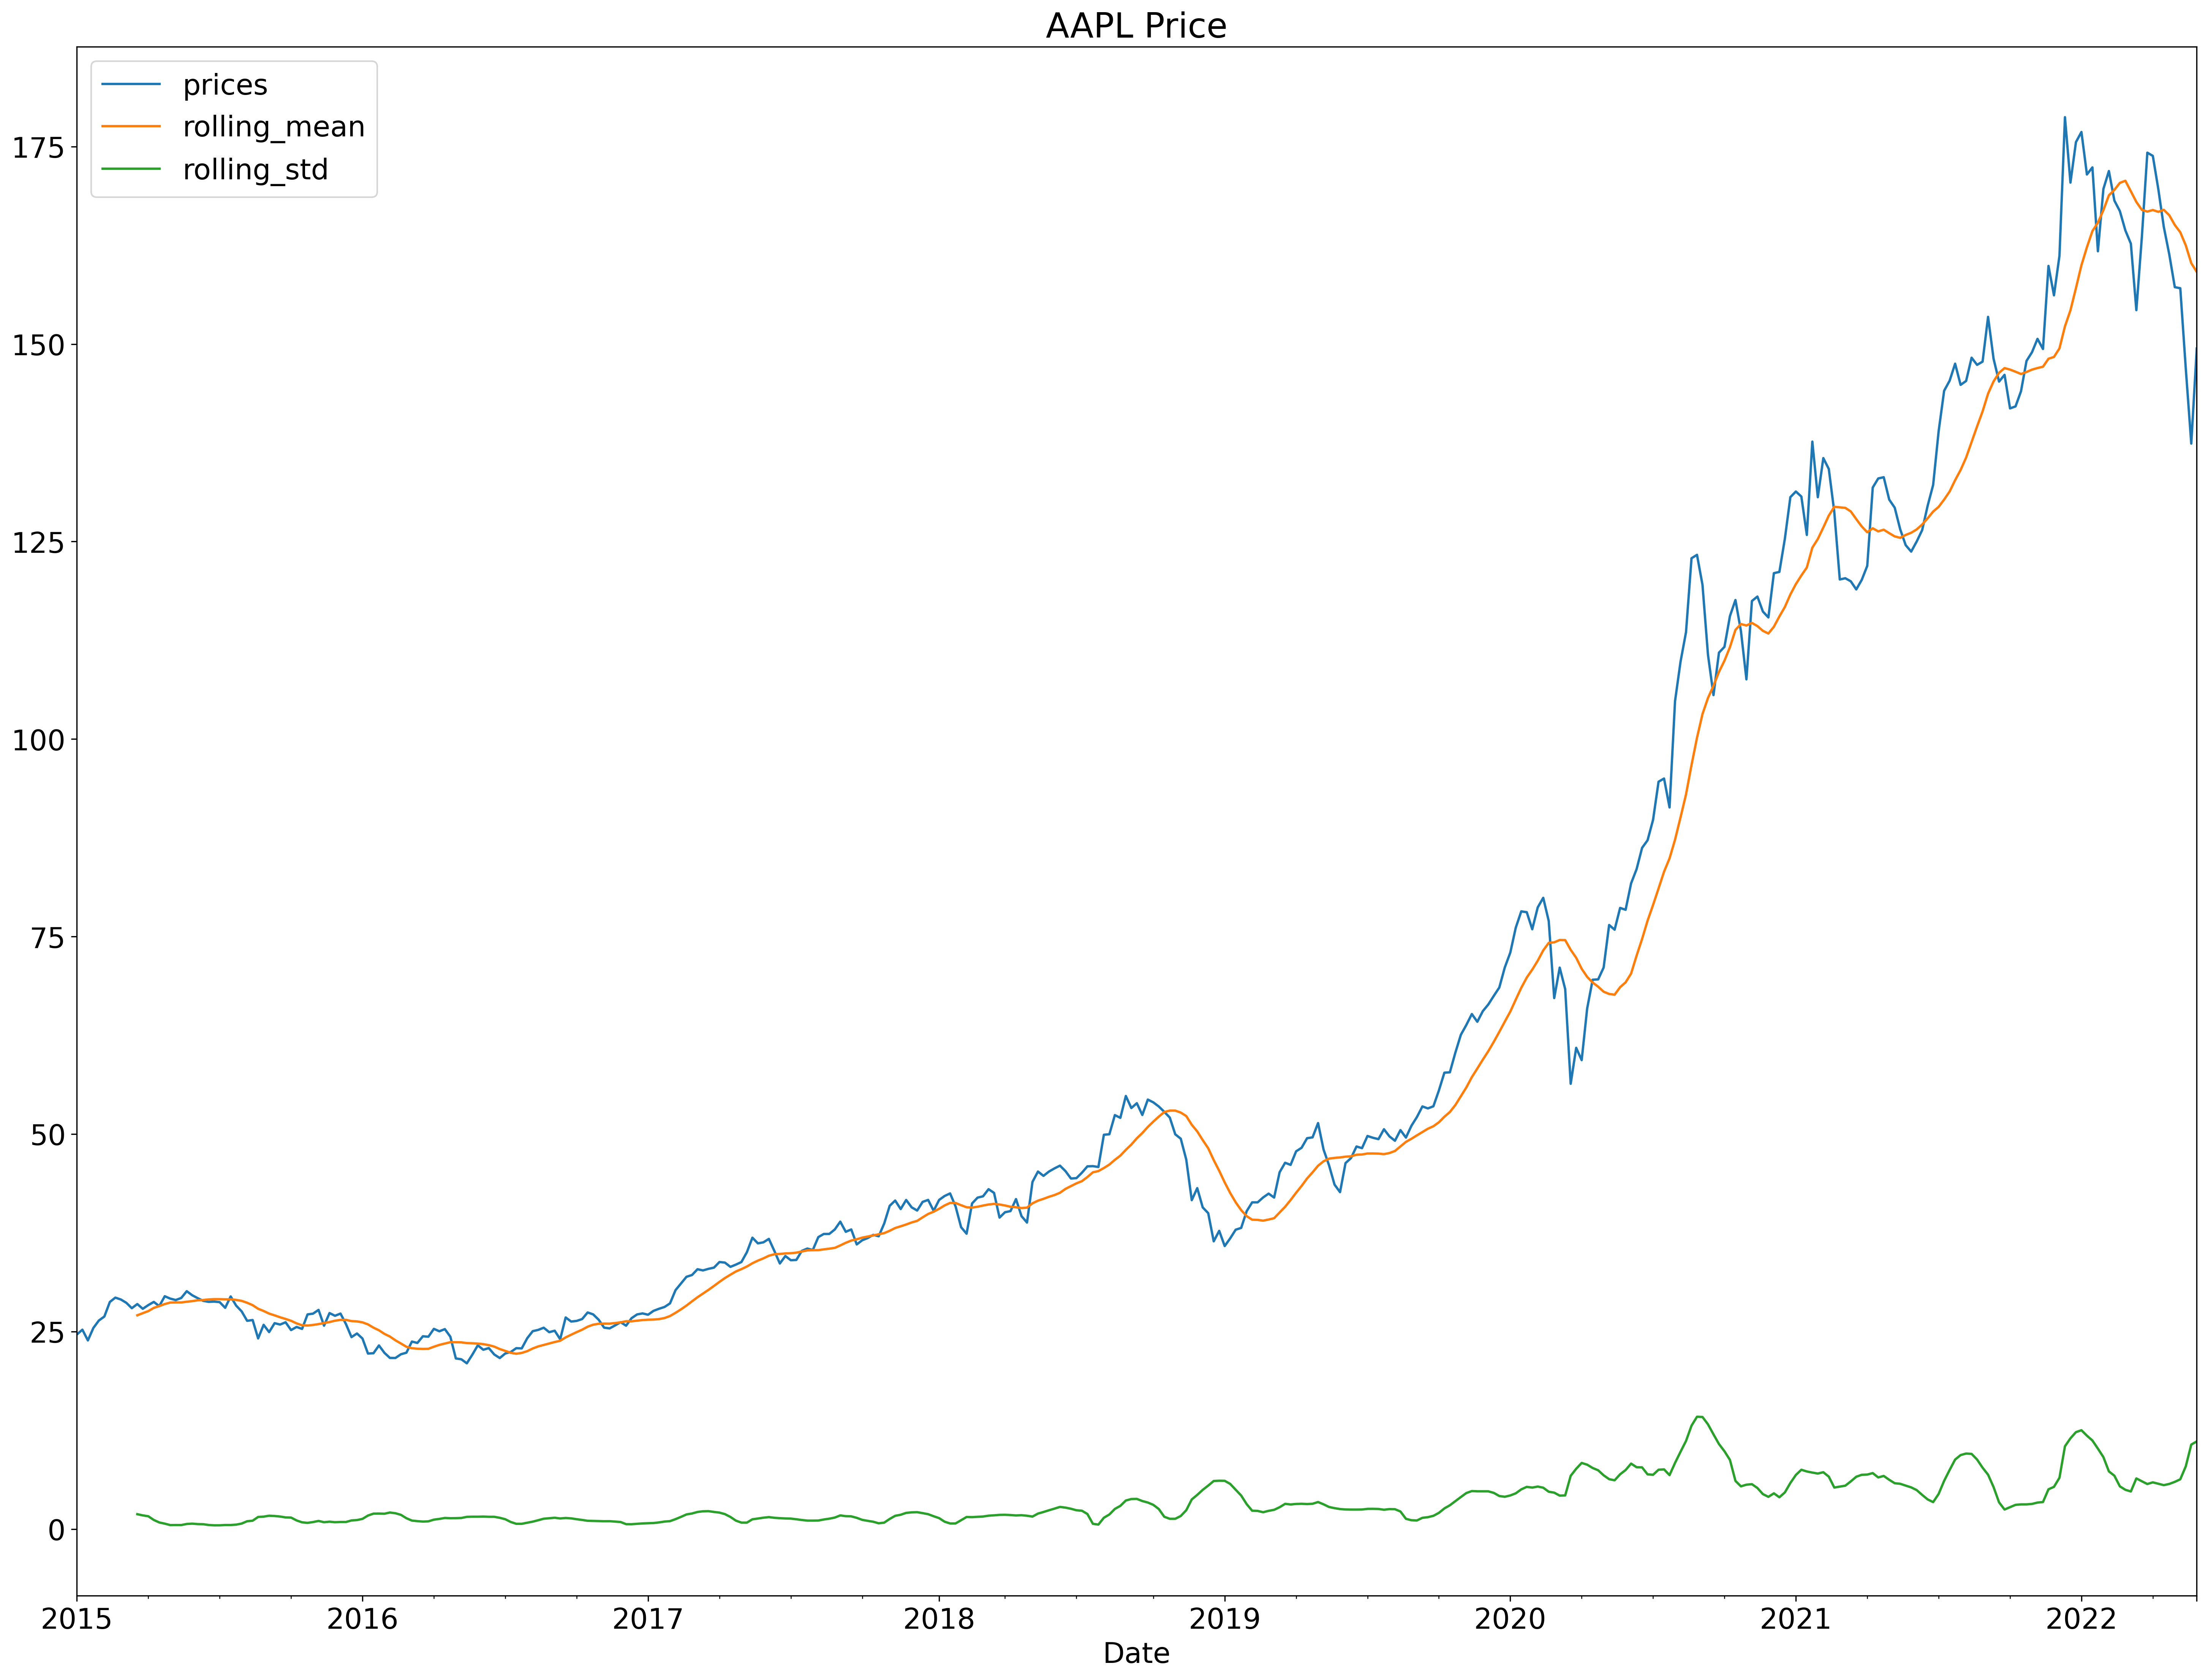

In [3]:
#Add the rolling mean and standard deviation:
WINDOW_SIZE = 12
dataset['rolling_mean'] = dataset.prices.rolling(window=WINDOW_SIZE).mean()
dataset['rolling_std'] = dataset.prices.rolling(window=WINDOW_SIZE).std()
dataset.plot(title='AAPL Price');

From the preceding plot, we can see that there is a non-linear growth pattern in the 12-month moving average and that the rolling standard deviation increases over time. That is why we decided to use the multiplicative model.

### Classical Approach of Decomposition

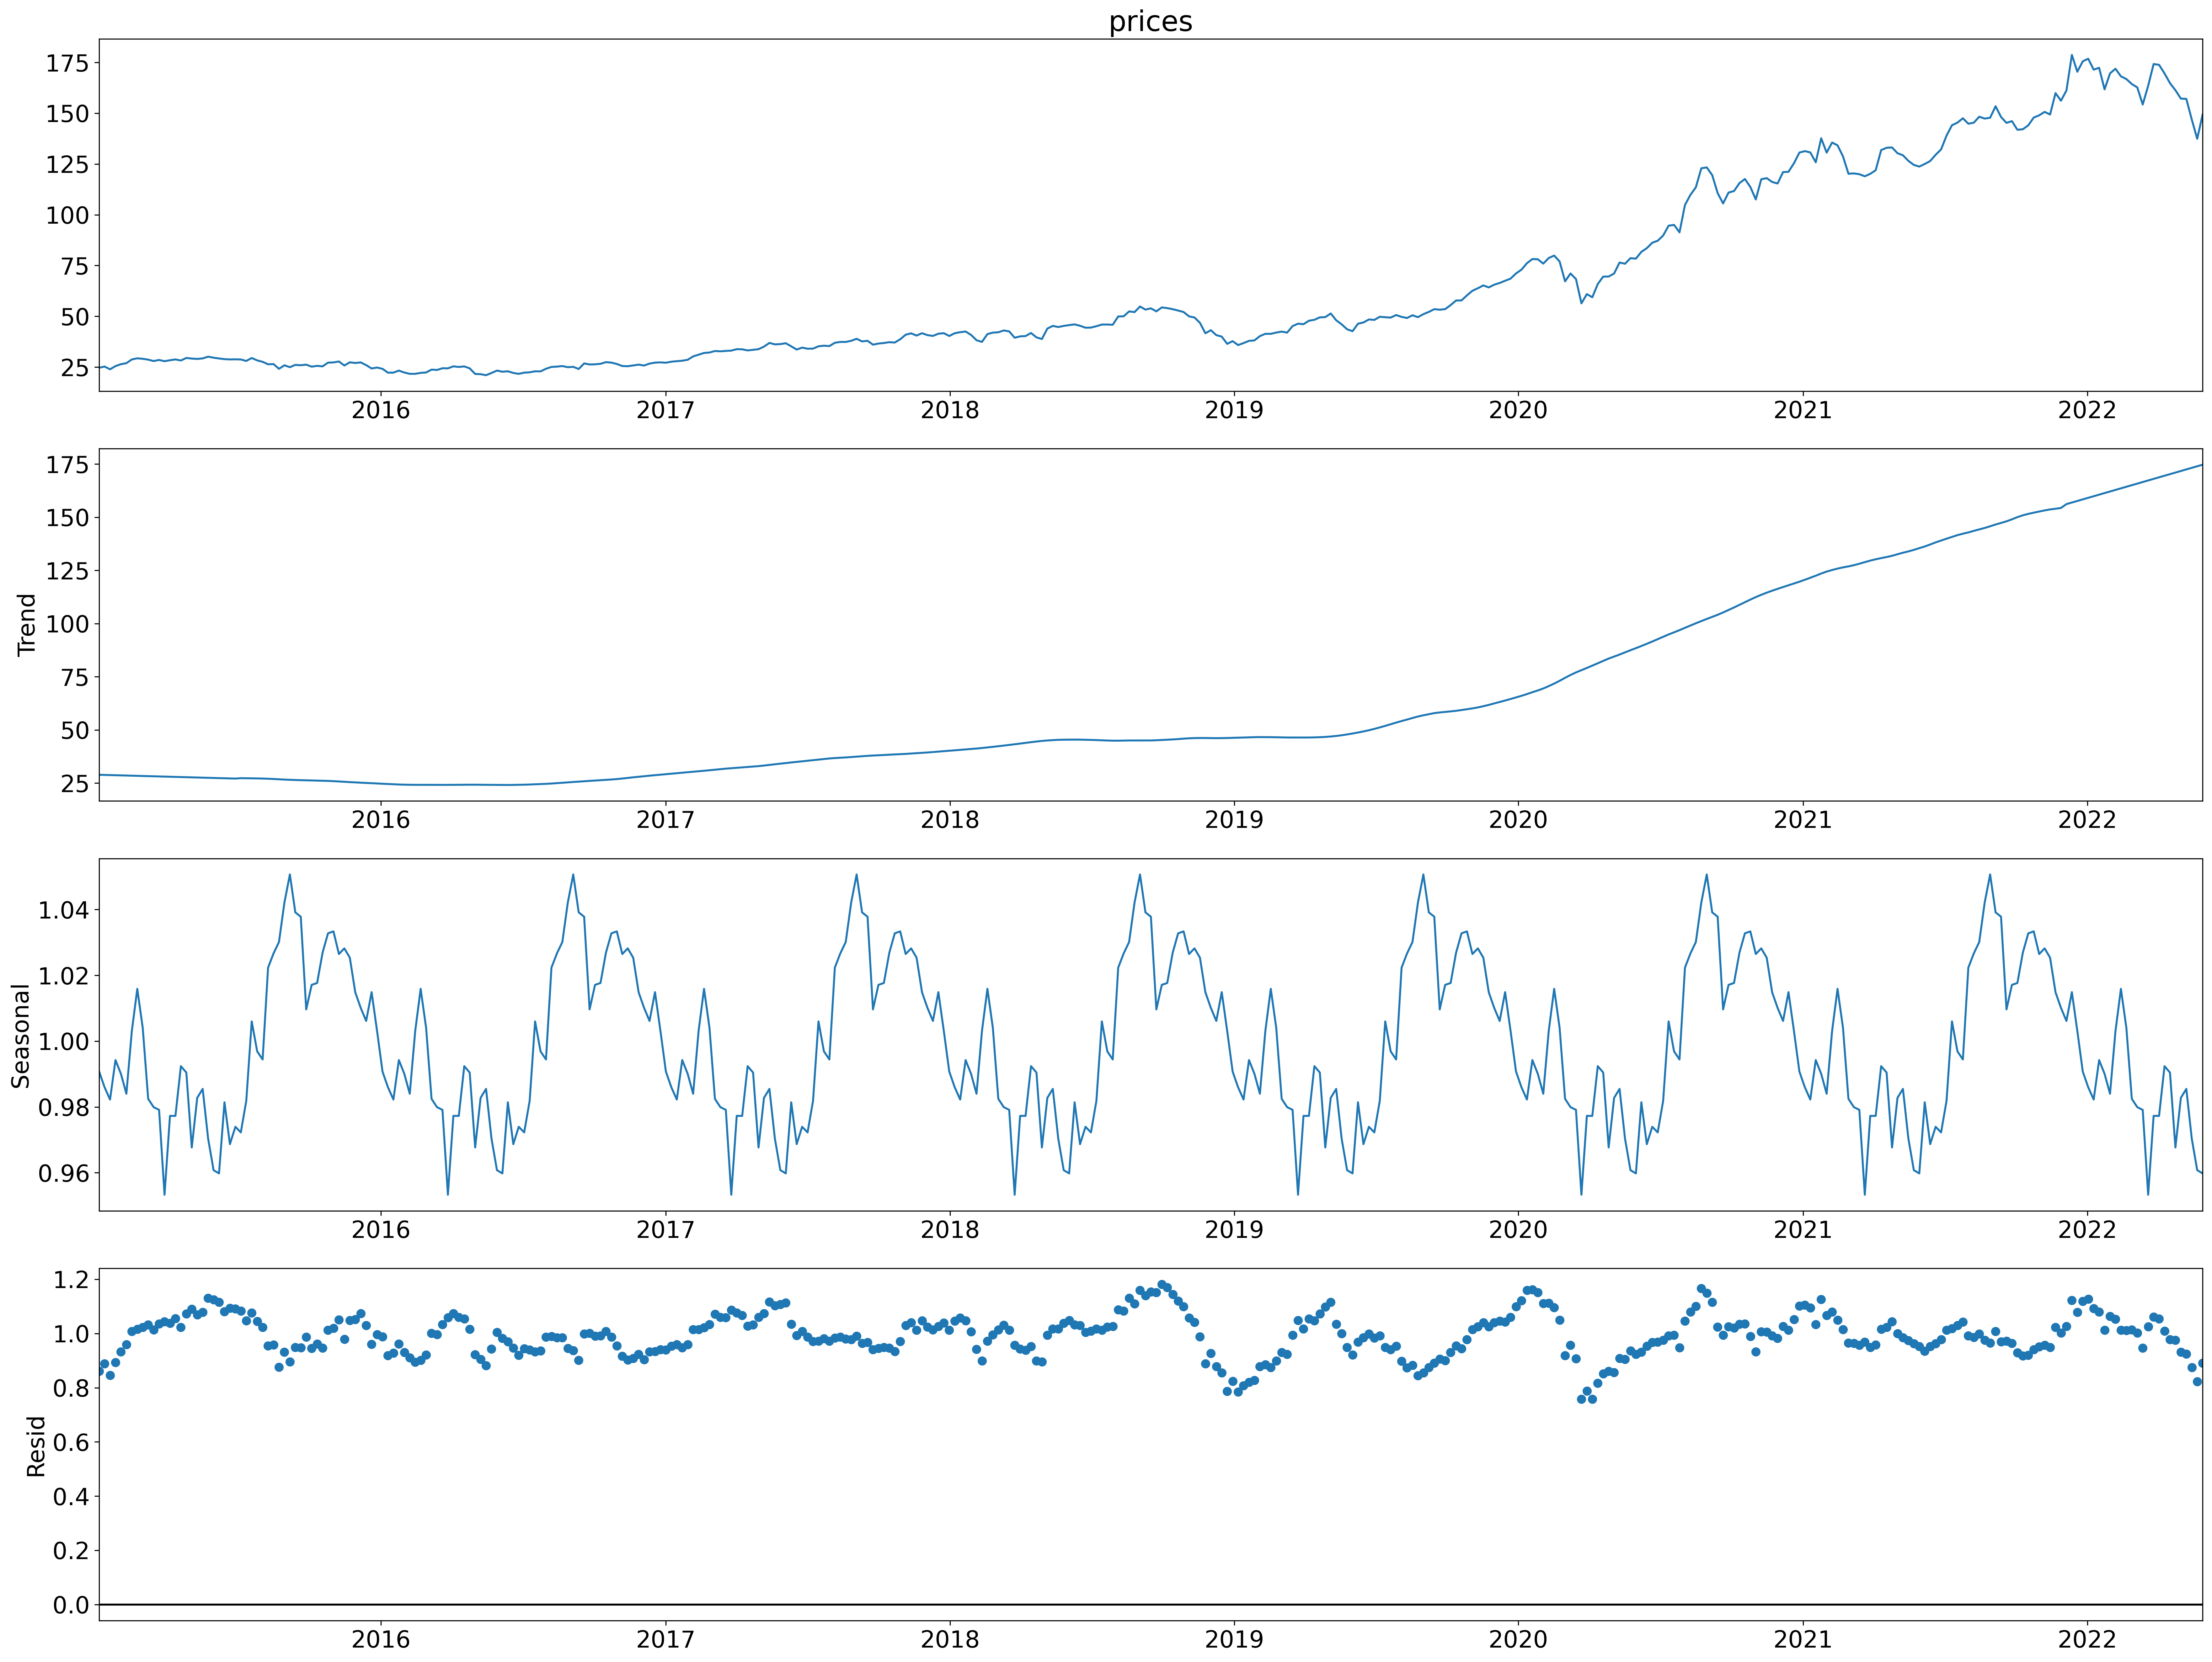

In [4]:
decomposition_results = seasonal_decompose(dataset.prices, model = 'multiplicative', extrapolate_trend = 'freq') #you can try different period value
decomposition_results.plot();

In the decomposition plot, we can see the extracted component series: trend, seasonal, and random (residual). To evaluate whether the decomposition makes sense, we can look at the random component. If there is no discernible pattern (in other words, the random component is indeed random), then the fit makes sense.

### STL Decomposition

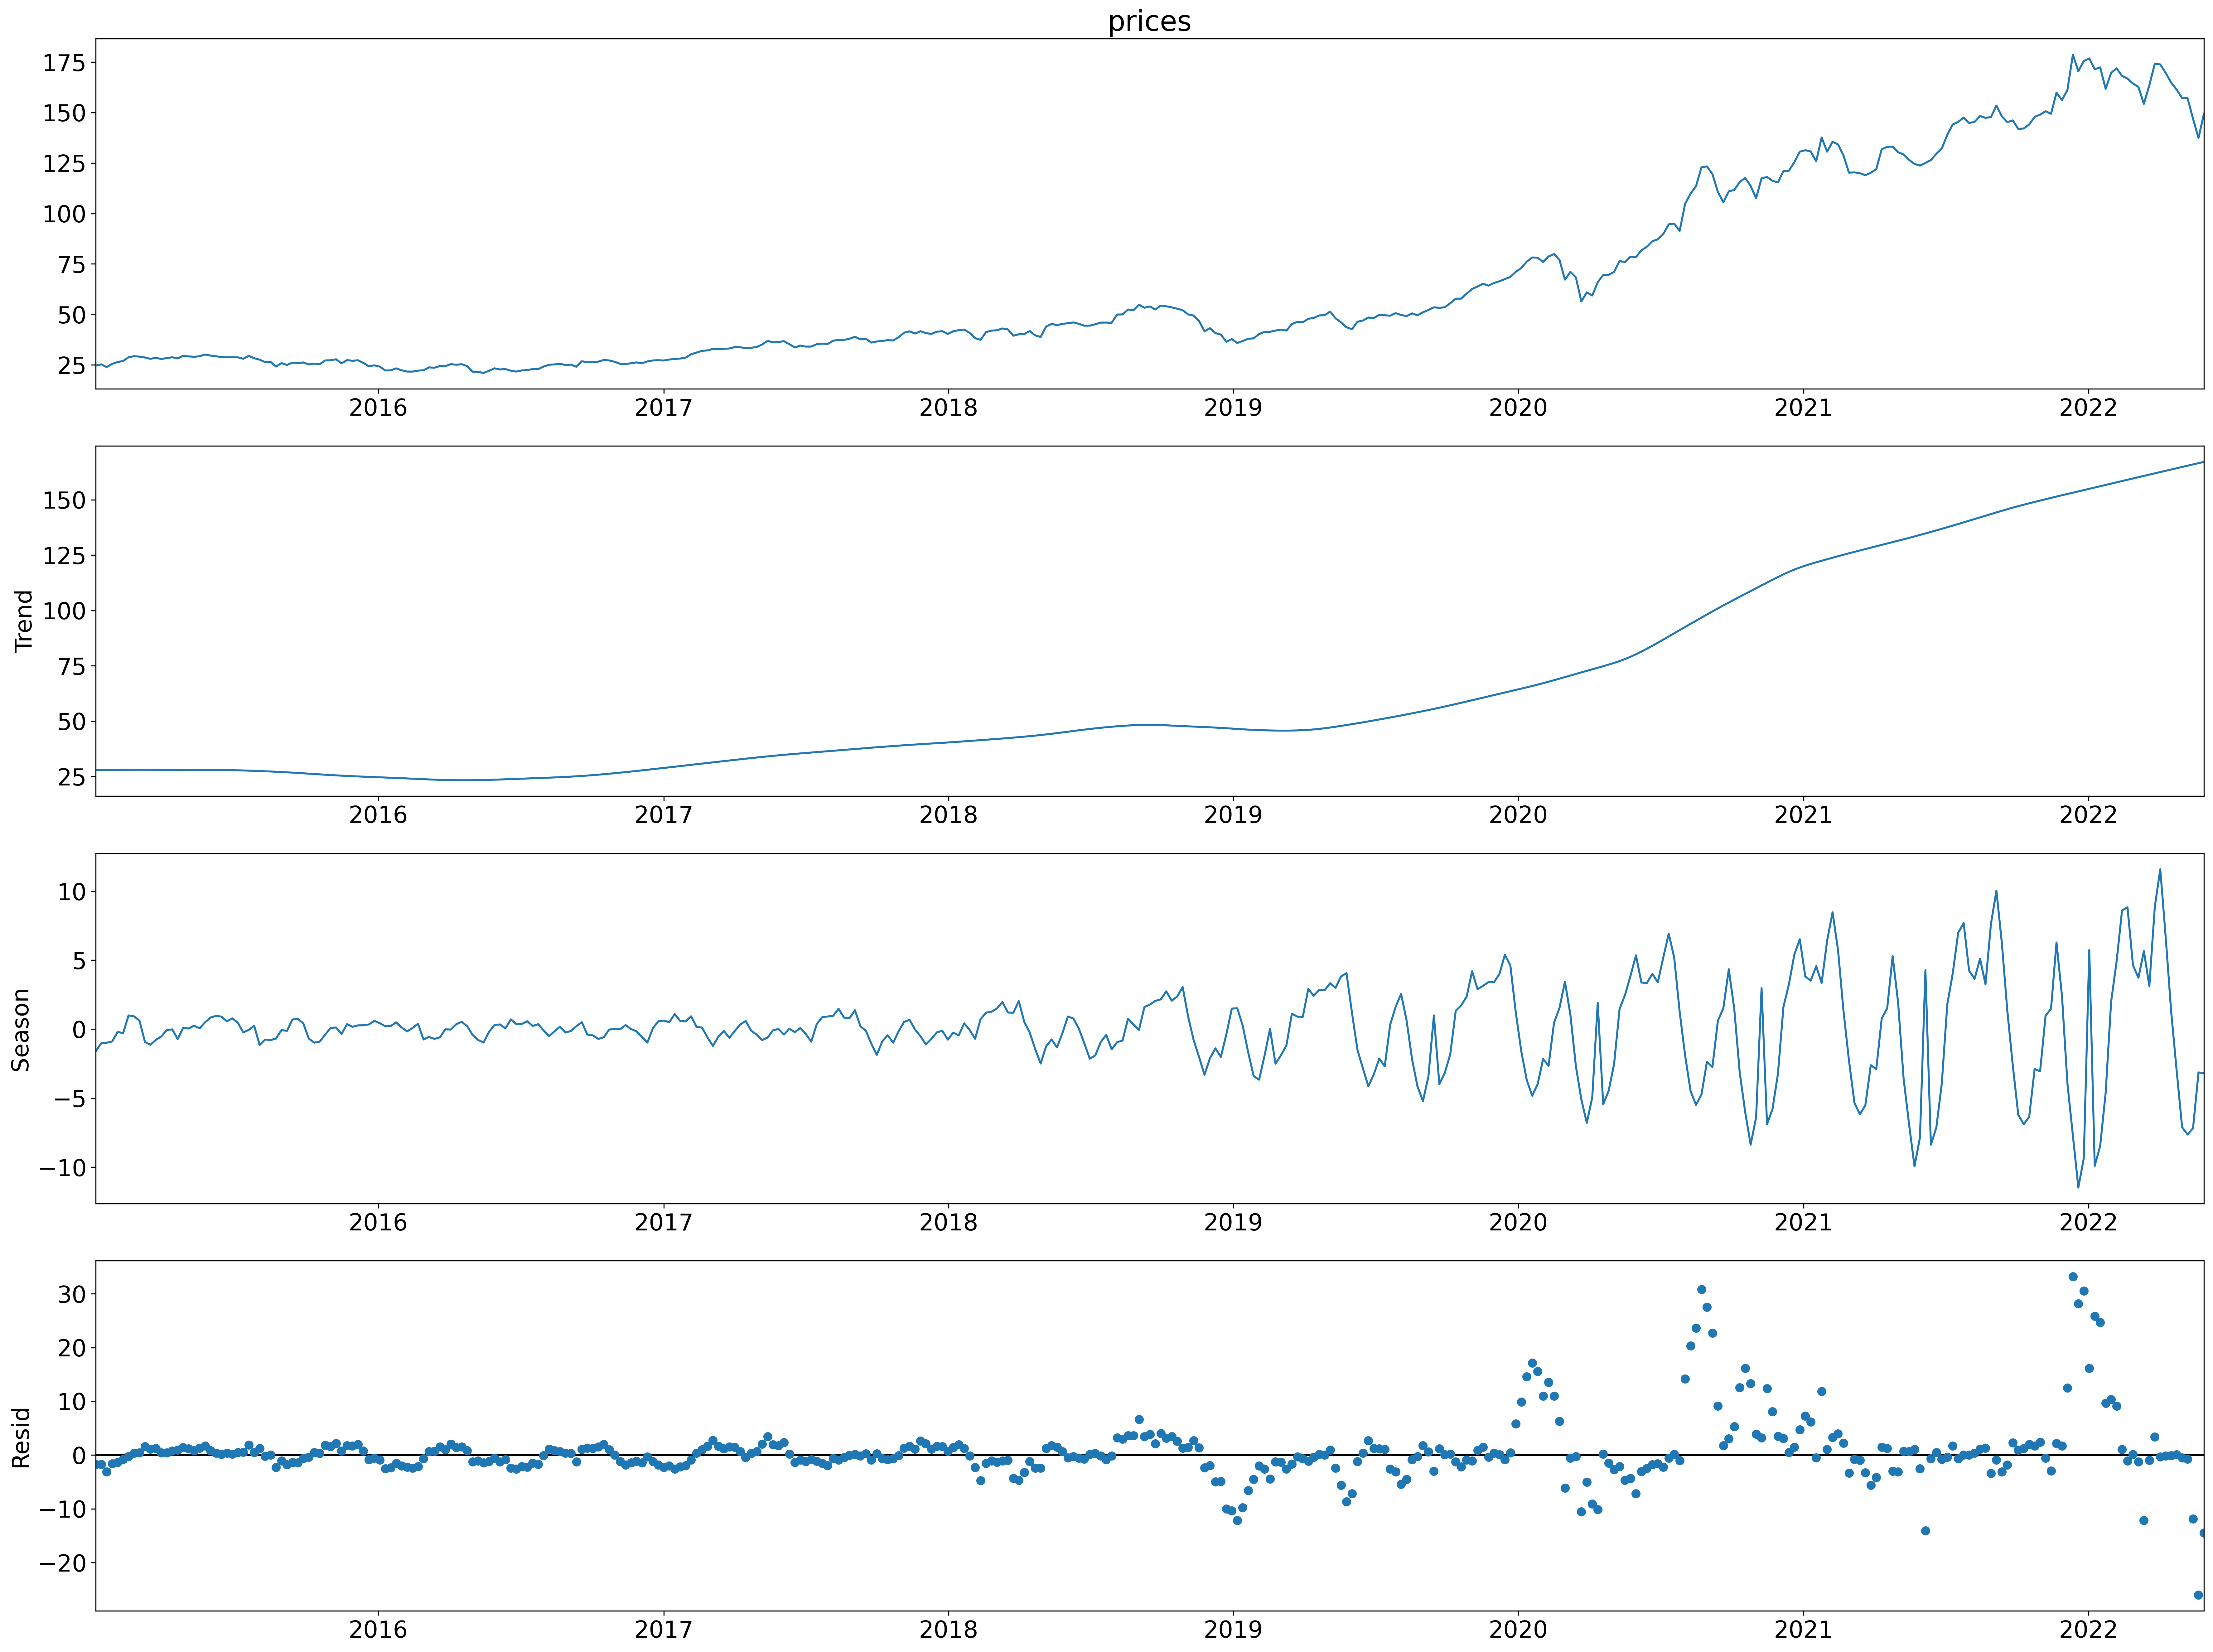

In [5]:
#Set robust to True to handle outliers
dt = dataset['prices'].copy()
res = STL(dt, seasonal=11, period=30, robust = True).fit() 
'''
We can change the smoothness of the trend-cycle and the seasonal components by passing 
an integer into the trend and seasonal arguments in the STL function. 
The seasonal argument is set to 7 by default (it is also recommended that you use 
a seasonal smoother greater than or equal to 7).
'''
res.plot()
plt.show()

You should notice the seasonal component increases with time. You can try different period for STL and check yourself how it works:)

## Testing for stationarity in time series

A stationary time series is a series in which statistical properties such as mean, variance, and covariance are constant over time. Stationarity is a desired characteristic of time series as it makes modeling and extrapolating (forecasting) into the future more feasible. 

In the plot presenting the rolling mean and standard deviation of the AAPL prices, we have already seen that the statistics seem to increase over time, suggesting non-stationarity.

Next we will test our time series for stationarity. To do so, we employ the following methods:
- The Augmented Dickey-Fuller (ADF) test
- The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test 
- Plots of the (partial) autocorrelation function (PACF/ACF)

In [6]:
def adf_test(x):
    '''
    The null hypothesis of the ADF test states that 
    the time series is not stationary. 
    '''
    indices = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    return results

In [7]:
adf_test(dataset.prices)

Test Statistic              0.303069
p-value                     0.977485
# of Lags Used              0.000000
# of Observations Used    386.000000
Critical Value (1%)        -3.447405
Critical Value (5%)        -2.869057
Critical Value (10%)       -2.570774
dtype: float64

The null hypothesis of the ADF test states that the time series is not stationary. A p-value (0.977485) is greater than 0.05 and it means that deviation from the null hypothesis is not statistically significant, and the null hypothesis is not rejected. We can conclude that the series is not stationary.

In [8]:
#Define a function for running the KPSS test:
def kpss_test(x, h0_type='c'):
    '''
    The null hypothesis of the KPSS test is 
    that the time series is stationary. 
    '''
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    return results

In [9]:
kpss_test(dataset.prices)

Test Statistic            2.769037
p-value                   0.010000
# of Lags                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

The null hypothesis of the KPSS test is that the time series is stationary. With a p-value of 0.01 (or test statistic greater than the selected critical value), we have reasons to reject the null hypothesis in favor of the alternative one, meaning that the series is not stationary.

### Generate the ACF/PACF plots:

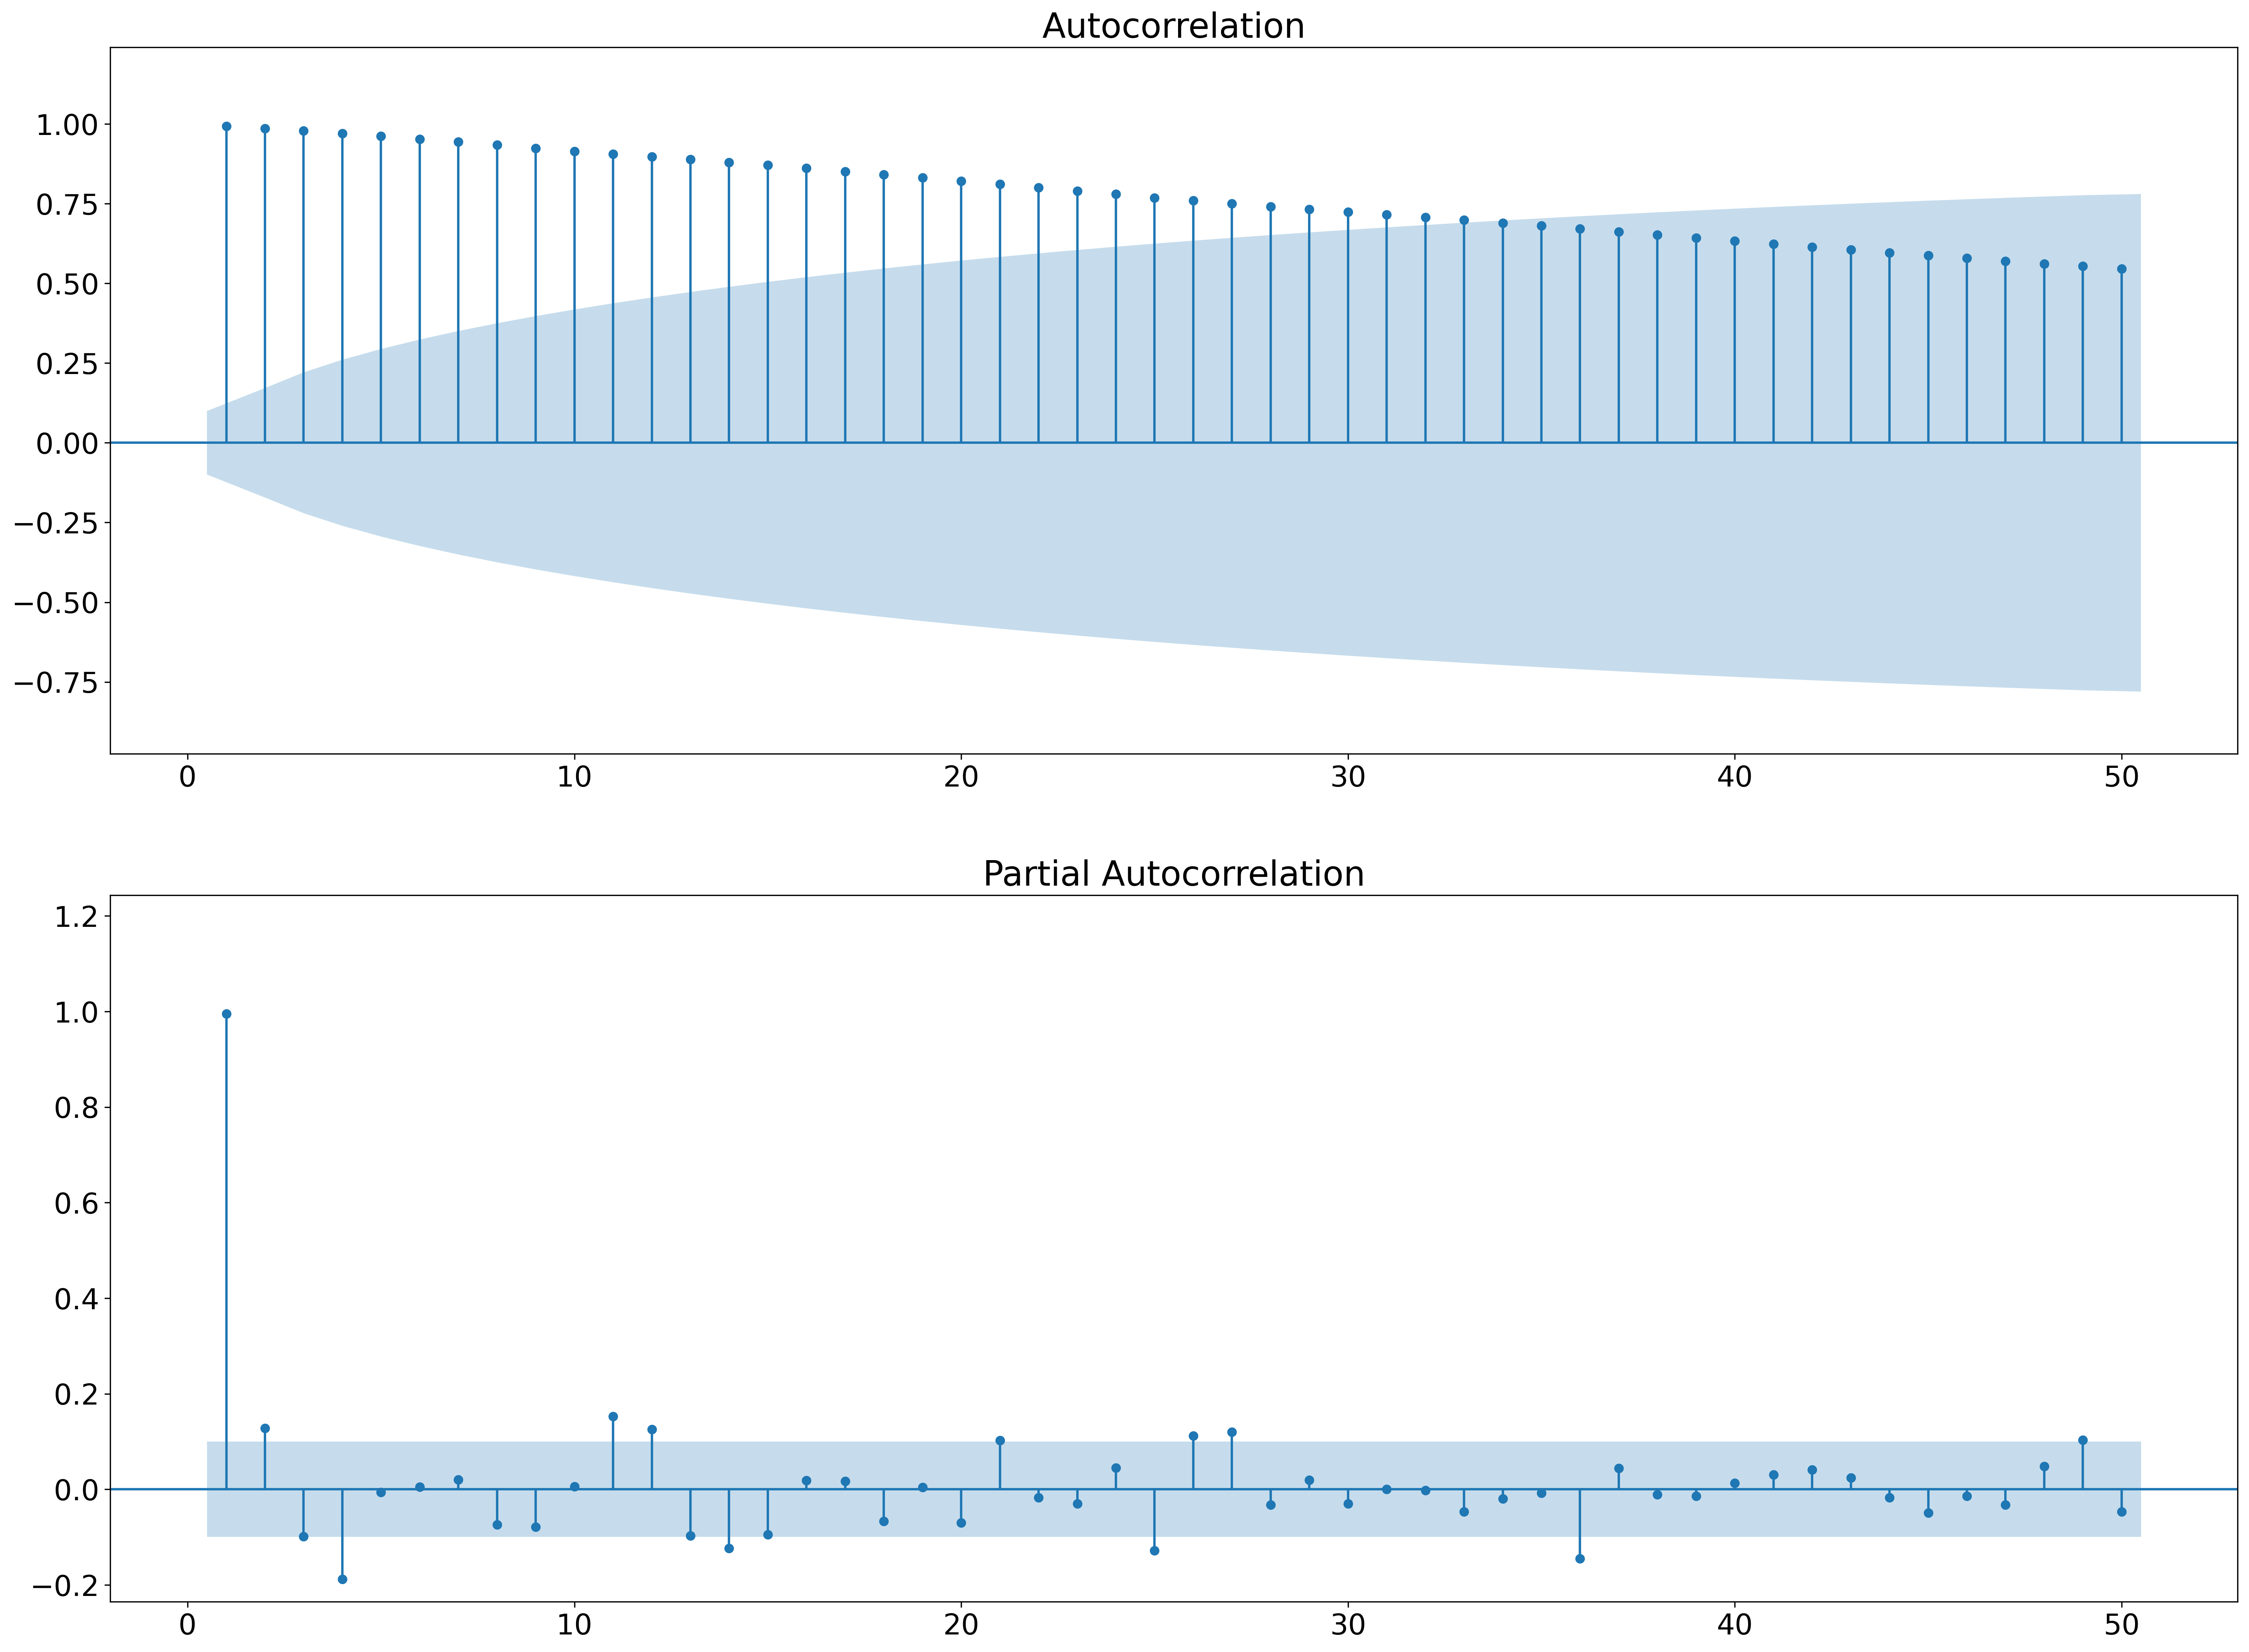

In [10]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1)
plot_acf(dataset.prices, ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, zero=False, auto_ylims = True)
plot_pacf(dataset.prices, ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, zero=False, auto_ylims = True);

In the ACF plot, we can see that there are significant autocorrelations (above the 95% confidence interval, corresponding to the selected 5% significance level). Also it's important to mention that Autocorrelation doesn't go to zero.

There are also some significant autocorrelations at lags 1 and 2, 4, 11, 12, etc in the PACF plot.

## Correcting for stationarity in time series

How to make a non-stationary time series stationary by differencing our series: taking the difference between the current observation and a lagged value (observation x time points before it)

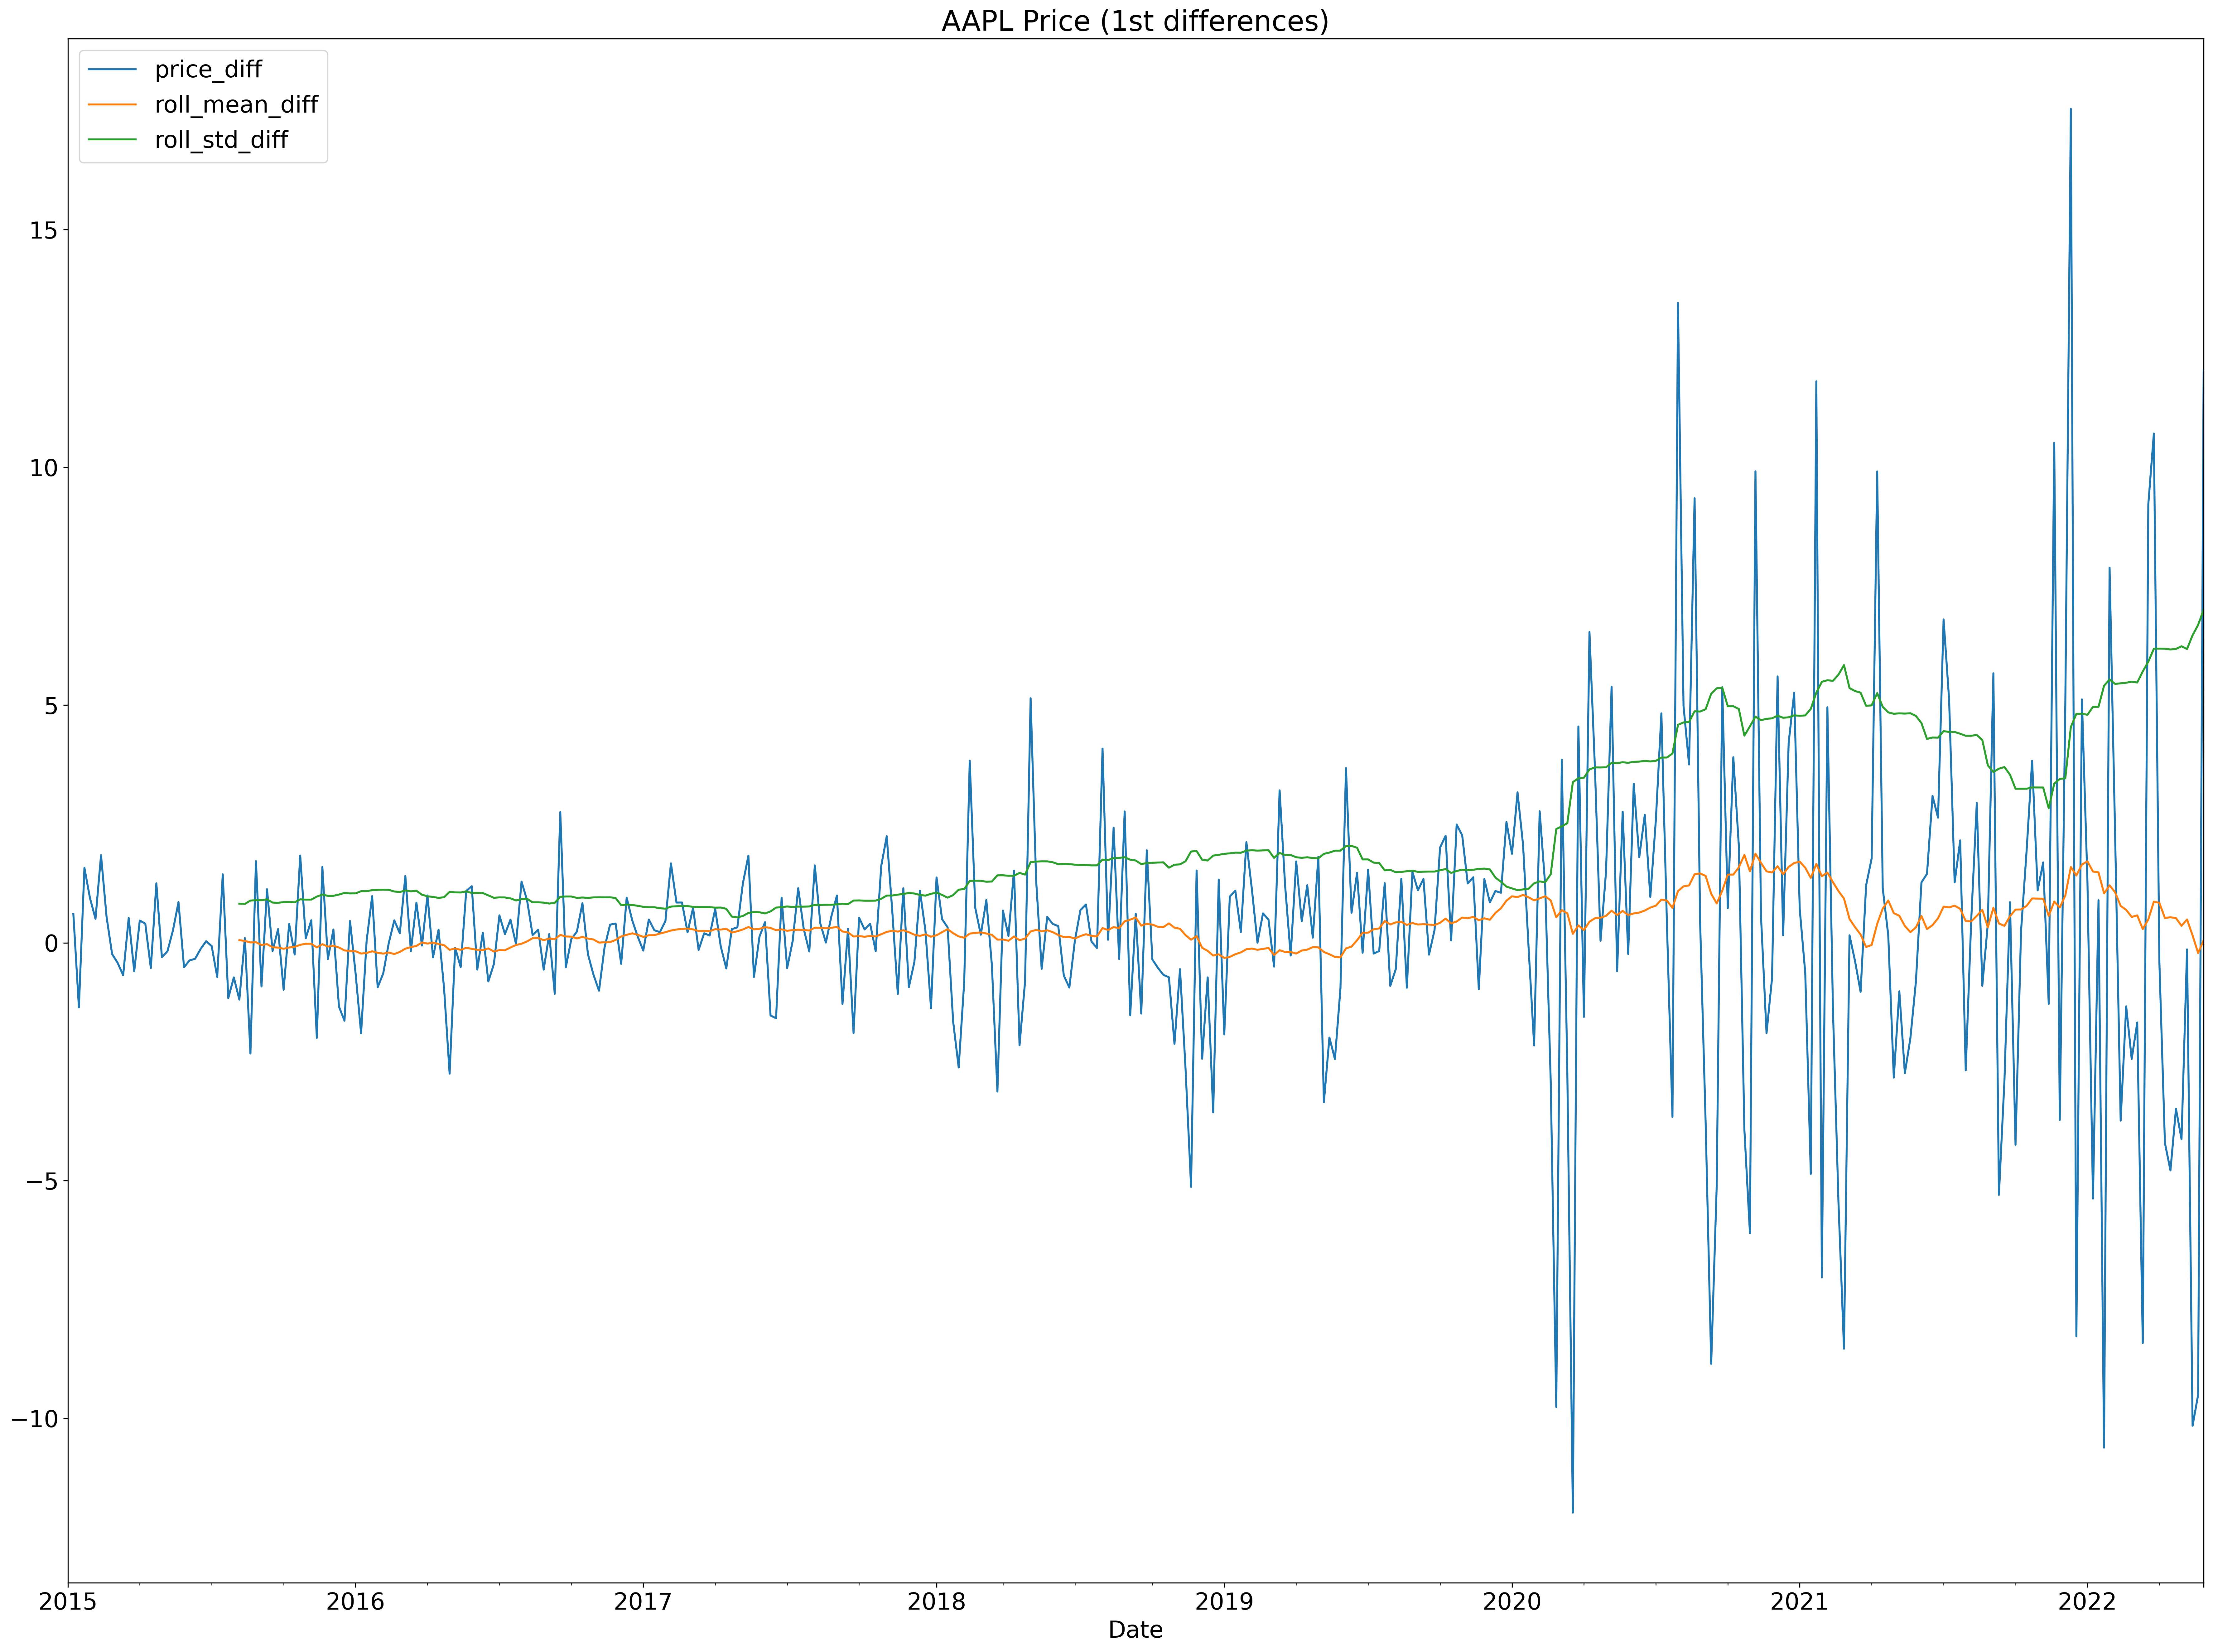

In [11]:
WINDOW = 31
selected_columns = ['price_diff', 'roll_mean_diff', 
                    'roll_std_diff']
dataset['price_diff'] = dataset.prices.diff(1)
dataset['roll_mean_diff'] = dataset.price_diff.rolling(WINDOW).mean()
dataset['roll_std_diff'] = dataset.price_diff.rolling(WINDOW).std()
dataset[selected_columns].plot(title='AAPL Price (1st differences)')

plt.tight_layout()
#plt.savefig('images/ch3_im12.png')
plt.show()

In [12]:
def test_autocorrelation(x, n_lags=50, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''
    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha, zero=False, auto_ylims = True)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha, zero=False, auto_ylims = True)

    return fig

ADF test statistic: -9.93 (p-val: 0.00)
KPSS test statistic: 0.24 (p-val: 0.10)


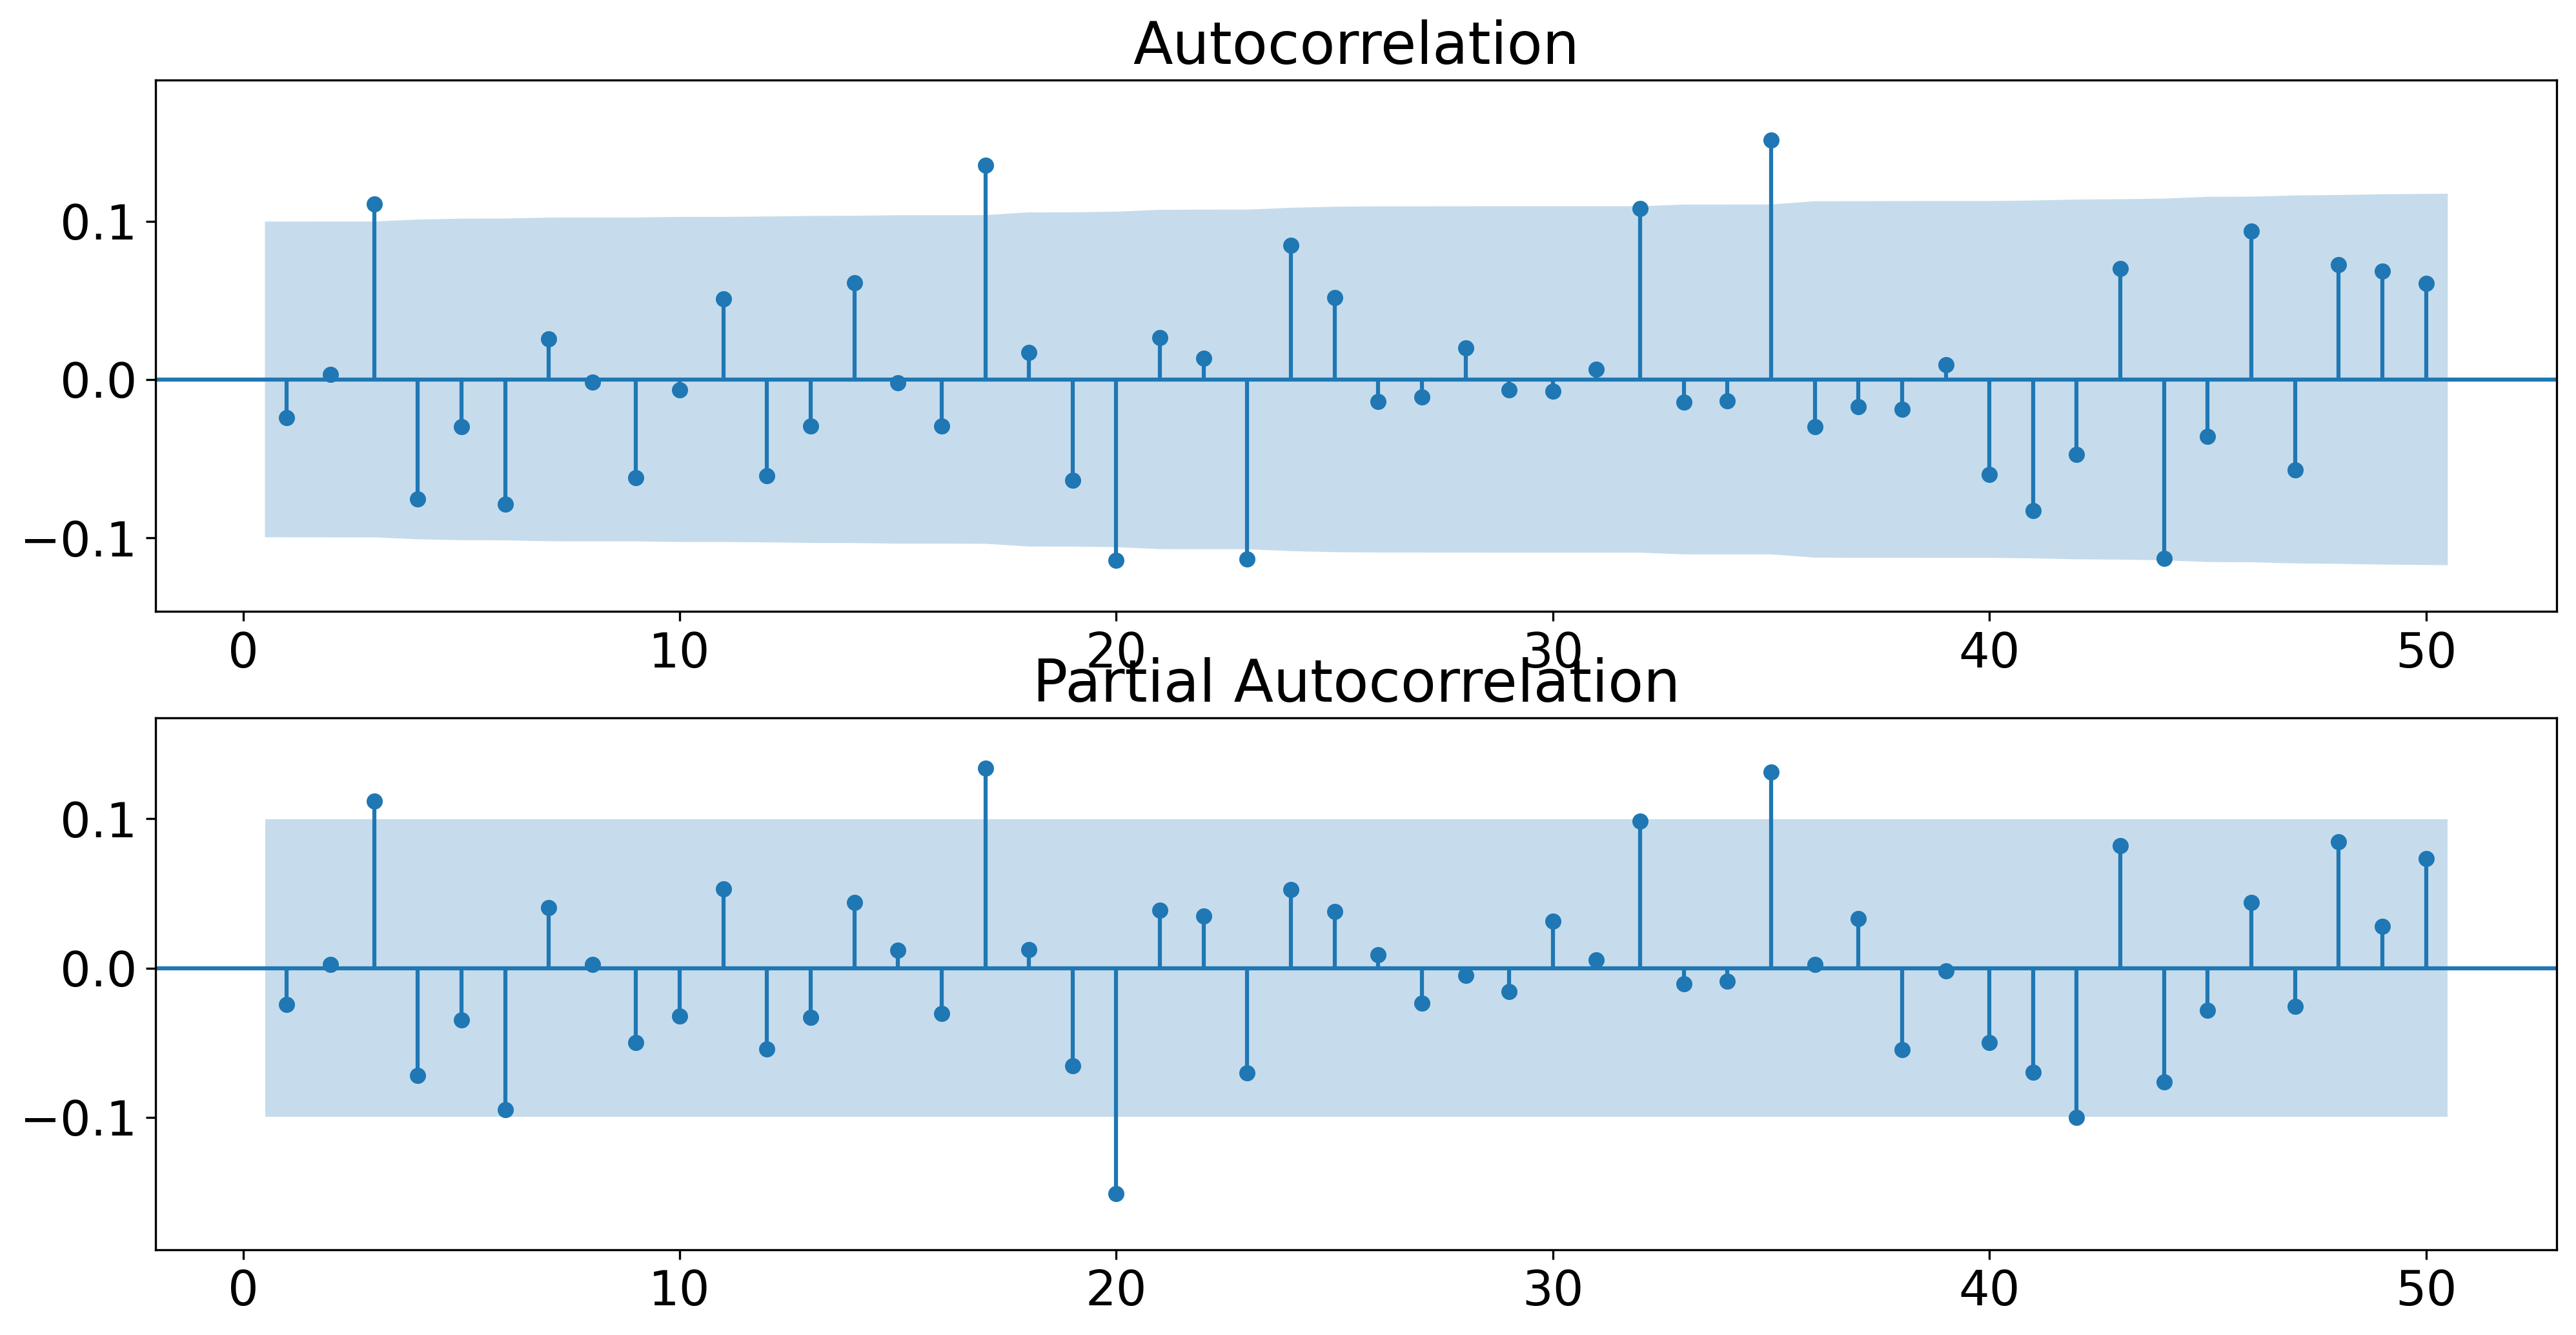

In [13]:
test_autocorrelation(dataset.price_diff.dropna()); # first item is NA

After applying the first differences, the series became stationary at the 5% significance level (according to both tests). In the ACF/PACF plots, we can see that there was a significant value of the function at lags 3. Let's try to model our time series.

## Modeling time series with ARIMA class models

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

***
The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0. In our case we needed the first order of differencing to make our series stationary, so d = 1.

You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

#### By setting the parameters of the ARIMA model, we can obtain some special cases:
- ARIMA (0,0,0): White noise
- ARIMA (0,1,0) without constant: Random walk
- ARIMA (p,0,q): ARMA(p, q)
- ARIMA (p, 0, 0): AR(p) model
- ARIMA (0, 0, q): MA(q) model
- ARIMA (0,1,2): Damped Holt's model
- ARIMA (0,1,1) without constant: SES model
- ARIMA (0,2,2): Holt's linear method with additive errors

One of the known weaknesses of the ARIMA class models in the financial context is their inability to capture volatility clustering that is observed in most of the financial assets.

In [14]:
dataset.head()

prices  rolling_mean  rolling_std  price_diff  roll_mean_diff  \
Date                                                                           
2015-01-04  24.644018           NaN          NaN         NaN             NaN   
2015-01-11  25.248114           NaN          NaN    0.604095             NaN   
2015-01-18  23.891148           NaN          NaN   -1.356966             NaN   
2015-01-25  25.466763           NaN          NaN    1.575615             NaN   
2015-02-01  26.408978           NaN          NaN    0.942215             NaN   

            roll_std_diff  
Date                       
2015-01-04            NaN  
2015-01-11            NaN  
2015-01-18            NaN  
2015-01-25            NaN  
2015-02-01            NaN

In [15]:
X = dataset.prices
X = X.astype('float32')

def prepare_dataset(X):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.90)
    train, validation = X[0:train_size], X[train_size:]
    return train, validation

train, validation = prepare_dataset(dataset.prices)
print(len(train)); print(len(validation)) # 348, 39

348
39


### Walk-forward validation
We will be using walk-forward validation in our time series modeling. Though walk-forward framework could be time expensive in the case of big data, but for statistical model, time is not a constraint and walk-forward validation is the most preferred solution to get most accurate results. This involves moving along the series one step at a time. Thus, walk-forward is a form of out-of-sample testing which takes it the furthest and considered a robust approach.

The walk-forward procedure works as follows:

1. Select a window size which is max. time duration and optimize the strategy on the first window.
2. Train & fit the model using all the data available on or before the selected window.
3. Once the model’s formed and parameters are established for the selected time period, generate the model outputs for all available data during the following time step.
4. Save the prediction as part of a result set.
5. Now move the window up so that all of the data through that window can be used for fitting and the data for the next time-step can be used for testing.
6. Repeat steps (2) to (5) adding the new predictions to the result set when new data comes in.


First, let's establish a baseline of performance. The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

In [16]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(validation)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = validation[i]
    history.append(obs)
   # print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(validation, predictions))
#print('RMSE: %.3f' % rmse)
print(f"The persistence model achieved an RMSE of {rmse}")

The persistence model achieved an RMSE of 6.361468207649604


In [17]:
def fit_model(history, arima_order):
    model = ARIMA(history, order = arima_order)
    return model.fit()

In [18]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    train, validation = prepare_dataset(X)
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(validation)):
        yhat = fit_model(history, arima_order).forecast()[0]
        predictions.append(yhat)
        history.append(validation[t])

    # calculate out of sample error
    rmse = sqrt(mean_squared_error(validation, predictions))
    residuals = [validation[i]-predictions[i] for i in range(len(validation))]
    return rmse, residuals

In [19]:
# evaluate manually configured ARIMA model
rmse, residuals = evaluate_arima_model(X, arima_order = (3, 1, 3))
rmse

6.389848935669262

In [20]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, residuals = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [21]:
# evaluate parameters and find the best model
p_values = range(0,5)
d_values = range(1,2)
q_values = range(0,5)

evaluate_models(dataset.prices, p_values, d_values, q_values)

ARIMA(0, 1, 0) RMSE=6.361
ARIMA(0, 1, 1) RMSE=6.424
ARIMA(0, 1, 2) RMSE=6.497
ARIMA(0, 1, 3) RMSE=6.412
ARIMA(0, 1, 4) RMSE=6.397
ARIMA(1, 1, 0) RMSE=6.434
ARIMA(1, 1, 1) RMSE=6.399
ARIMA(1, 1, 2) RMSE=6.508
ARIMA(1, 1, 3) RMSE=6.388
ARIMA(1, 1, 4) RMSE=6.457
ARIMA(2, 1, 0) RMSE=6.503
ARIMA(2, 1, 1) RMSE=6.517
ARIMA(2, 1, 2) RMSE=6.409
ARIMA(2, 1, 3) RMSE=6.361
ARIMA(2, 1, 4) RMSE=6.421
ARIMA(3, 1, 0) RMSE=6.431
ARIMA(3, 1, 1) RMSE=6.416
ARIMA(3, 1, 2) RMSE=6.306
ARIMA(3, 1, 3) RMSE=6.390
ARIMA(3, 1, 4) RMSE=6.416
ARIMA(4, 1, 0) RMSE=6.424
ARIMA(4, 1, 1) RMSE=6.458
ARIMA(4, 1, 2) RMSE=6.465
ARIMA(4, 1, 3) RMSE=6.417
ARIMA(4, 1, 4) RMSE=6.468
Best ARIMA(3, 1, 2) RMSE=6.306


In [22]:
# evaluate the best configured ARIMA model
rmse, residuals = evaluate_arima_model(X, arima_order = (3, 1, 2))
rmse 

6.30574296293507

#### Review Residual Errors

In [23]:
def arima_diagnostics(resids, n_lags=20):
    '''
    Function for diagnosing the fit of an ARIMA model by investigating the residuals.
    
    Parameters
    ----------
    resids : np.array
        An array containing the residuals of a fitted model
    n_lags : int
        Number of lags for autocorrelation plot
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        Created figure
    '''
     
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')

    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05, zero=False, auto_ylims = True)
    ax4.set_title('ACF plot')

    return fig

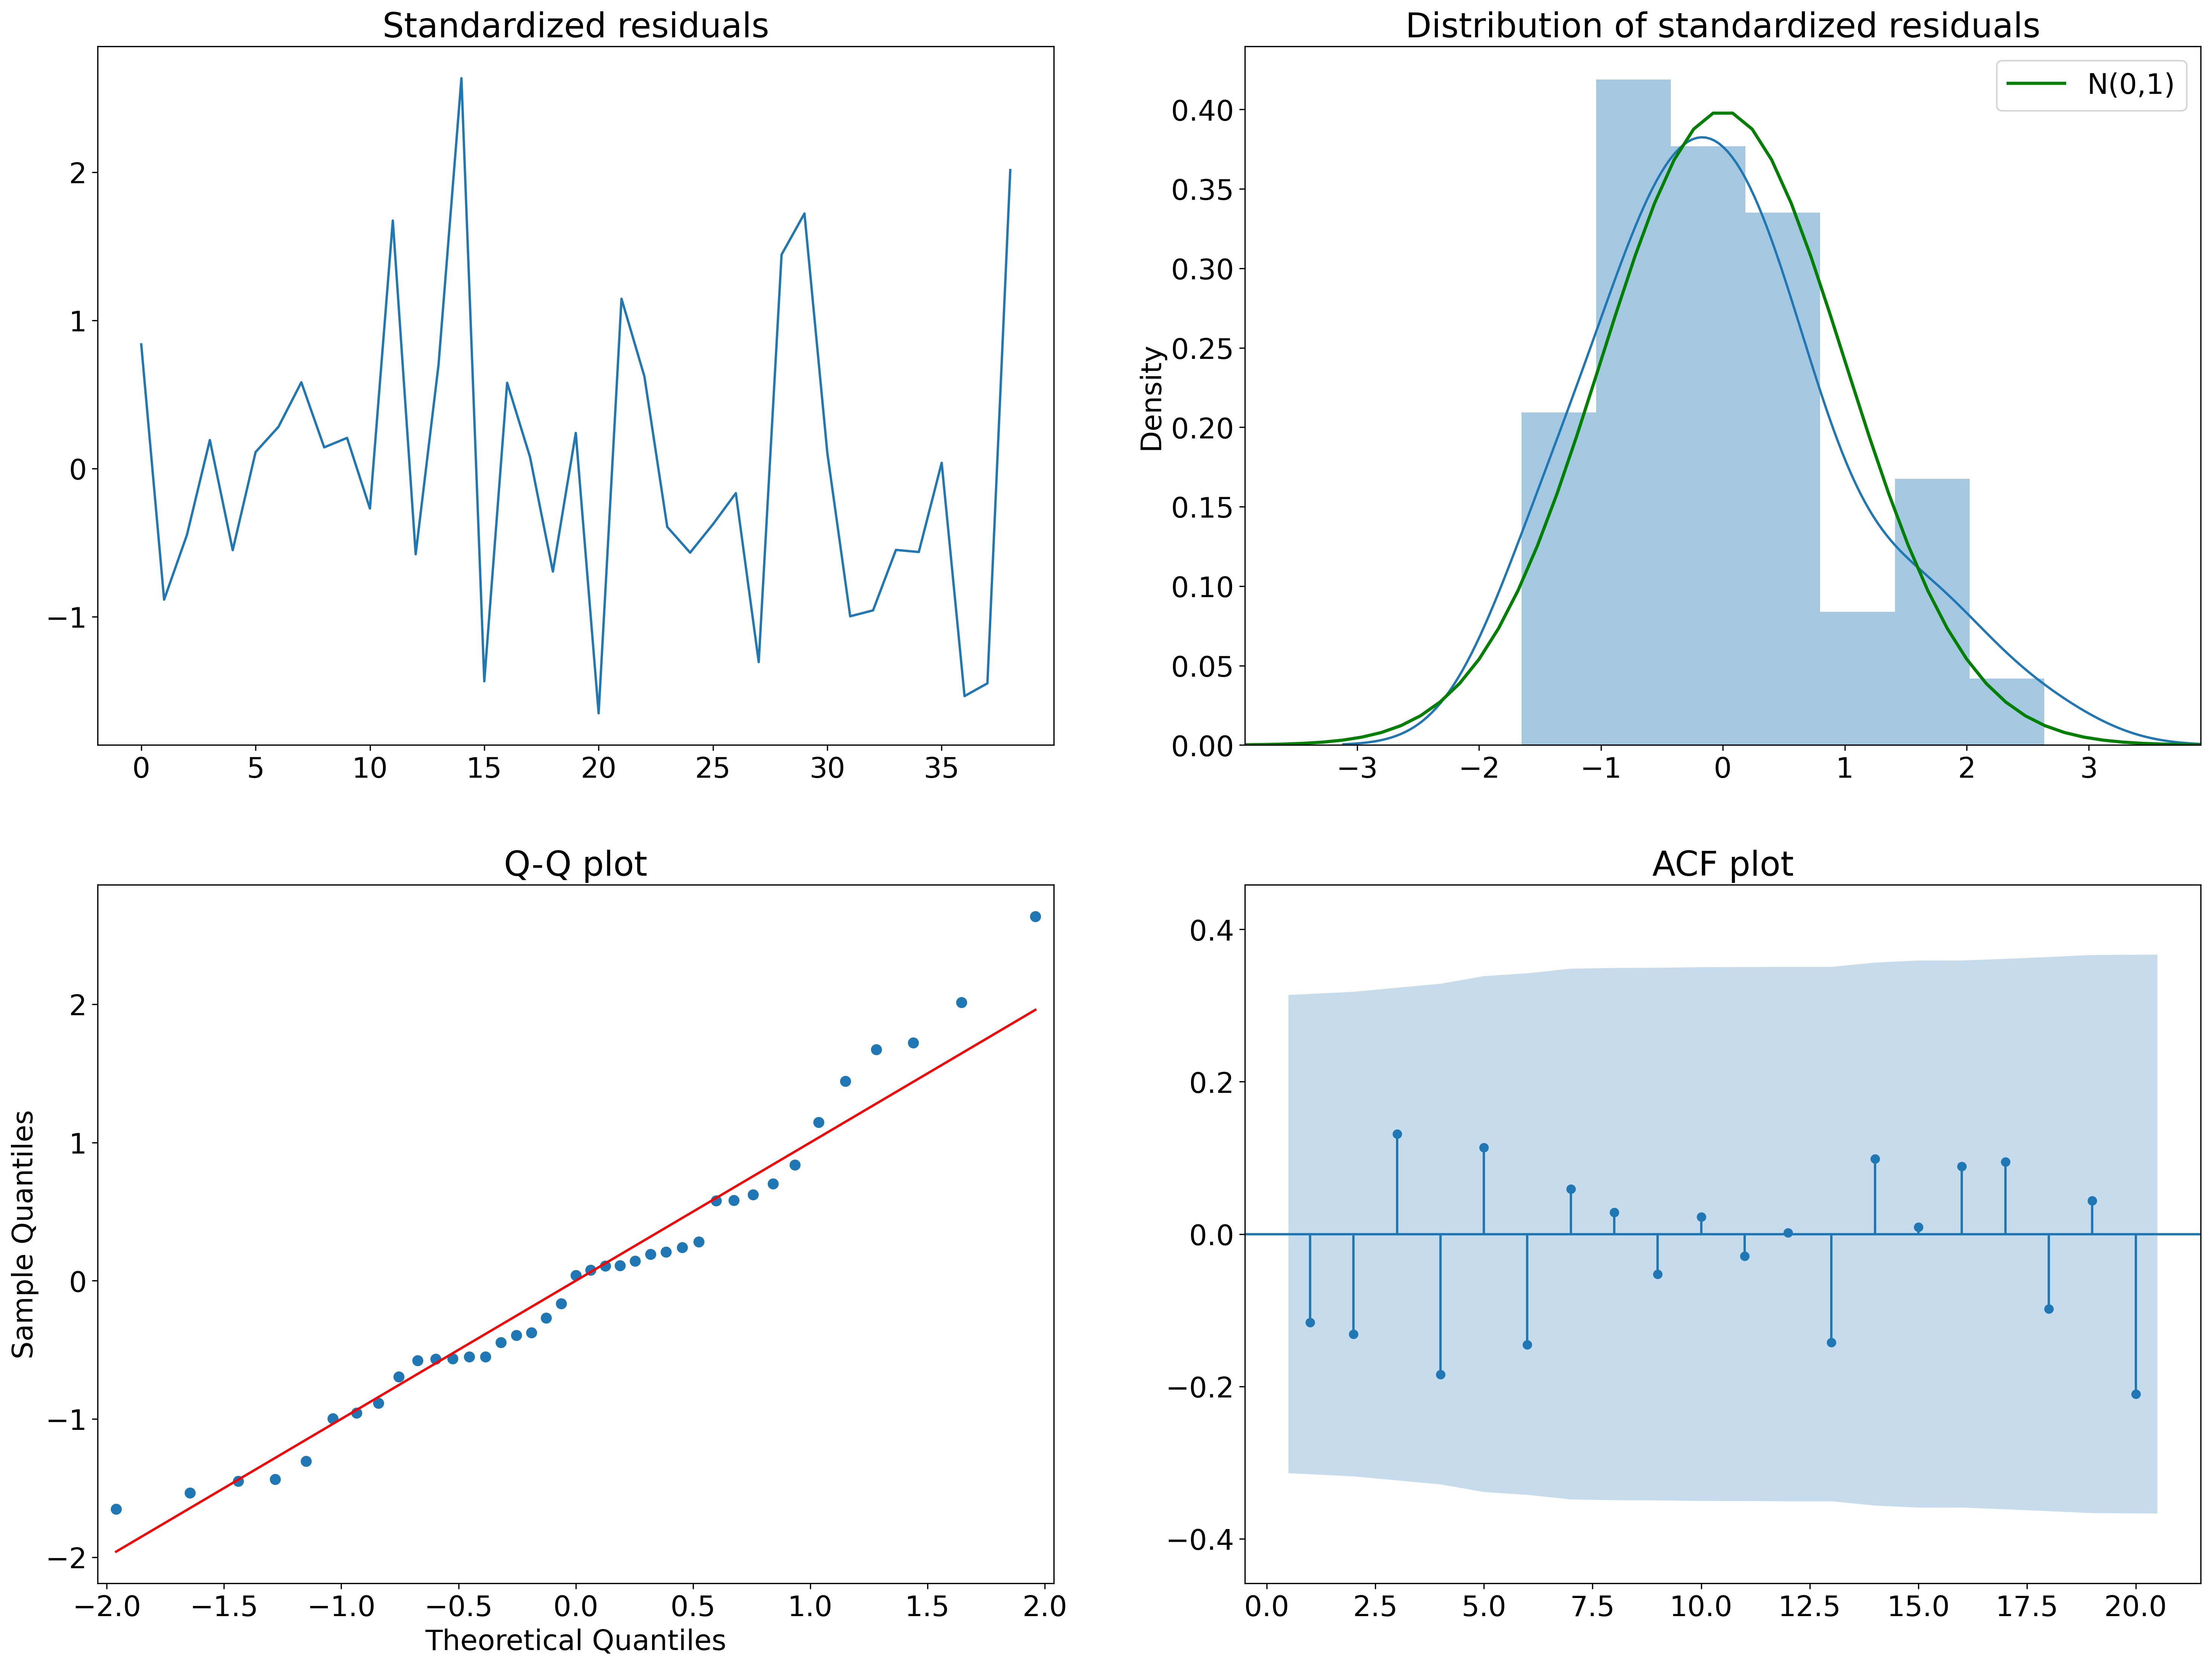

In [24]:
arima_diagnostics(residuals, 20);

I would say it's an okay fit. The average of the residuals is in a (-1; 1) range, which is close to 0, but could have been better. Inspecting the ACF plot leads to the conclusion that the residuals are not correlated. The tails of the distribution are slightly heavier than under normality, which we can observe in the Q-Q plot.

# Forecasting using ARIMA class models

In [25]:
# fit model
model = ARIMA(X, order=(3, 1, 2))
model_fit = model.fit()
# save model
model_fit.save('model.pkl')

In [26]:
#Let's get newer data for test
test = yf.download("AAPL", start='2022-06-01', end='2022-10-14', adjusted=True, progress=False)
test = test.resample('W').last().rename(columns={'Adj Close': 'prices'}).prices

In [27]:
def forecast_arima_model(X, test):
    history = [x for x in X]
    y = test.values
    # load model
    model_fit = ARIMAResults.load('model.pkl')
    model_order = (model_fit.model_orders['ar'], model_fit.model_orders['variance'], model_fit.model_orders['ma'])
    # make first prediction
    predictions = list()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(y[0])
    #print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
    
    #rolling forecasts
    for i in range(1, len(y)):
        # predict
        model = ARIMA(history, order = model_order).fit()
        yhat = model.forecast()[0]
        predictions.append(yhat)
        # observation
        obs = y[i]
        history.append(obs)
        print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    # report performance
    rmse = sqrt(mean_squared_error(y, predictions))
    print('RMSE: %.3f' % rmse)
    fig = plt.figure()
    plt.plot(y, label="AAPL prices")
    plt.plot(predictions, color='red', label="predicted AAPL prices")
    plt.legend(loc=1)
    plt.show()
    return rmse, fig

>Predicted=144.936, Expected=136.940
>Predicted=138.962, Expected=131.378
>Predicted=130.121, Expected=141.464
>Predicted=138.546, Expected=138.737
>Predicted=135.461, Expected=146.836
>Predicted=148.617, Expected=149.962
>Predicted=152.685, Expected=153.876
>Predicted=153.638, Expected=162.285
>Predicted=159.669, Expected=165.350
>Predicted=165.339, Expected=172.100
>Predicted=173.301, Expected=171.520
>Predicted=172.425, Expected=163.620
>Predicted=164.119, Expected=155.810
>Predicted=155.153, Expected=157.370
>Predicted=156.000, Expected=150.700
>Predicted=149.744, Expected=150.430
>Predicted=150.893, Expected=138.200
>Predicted=138.022, Expected=140.090
>Predicted=139.253, Expected=142.990
RMSE: 6.727


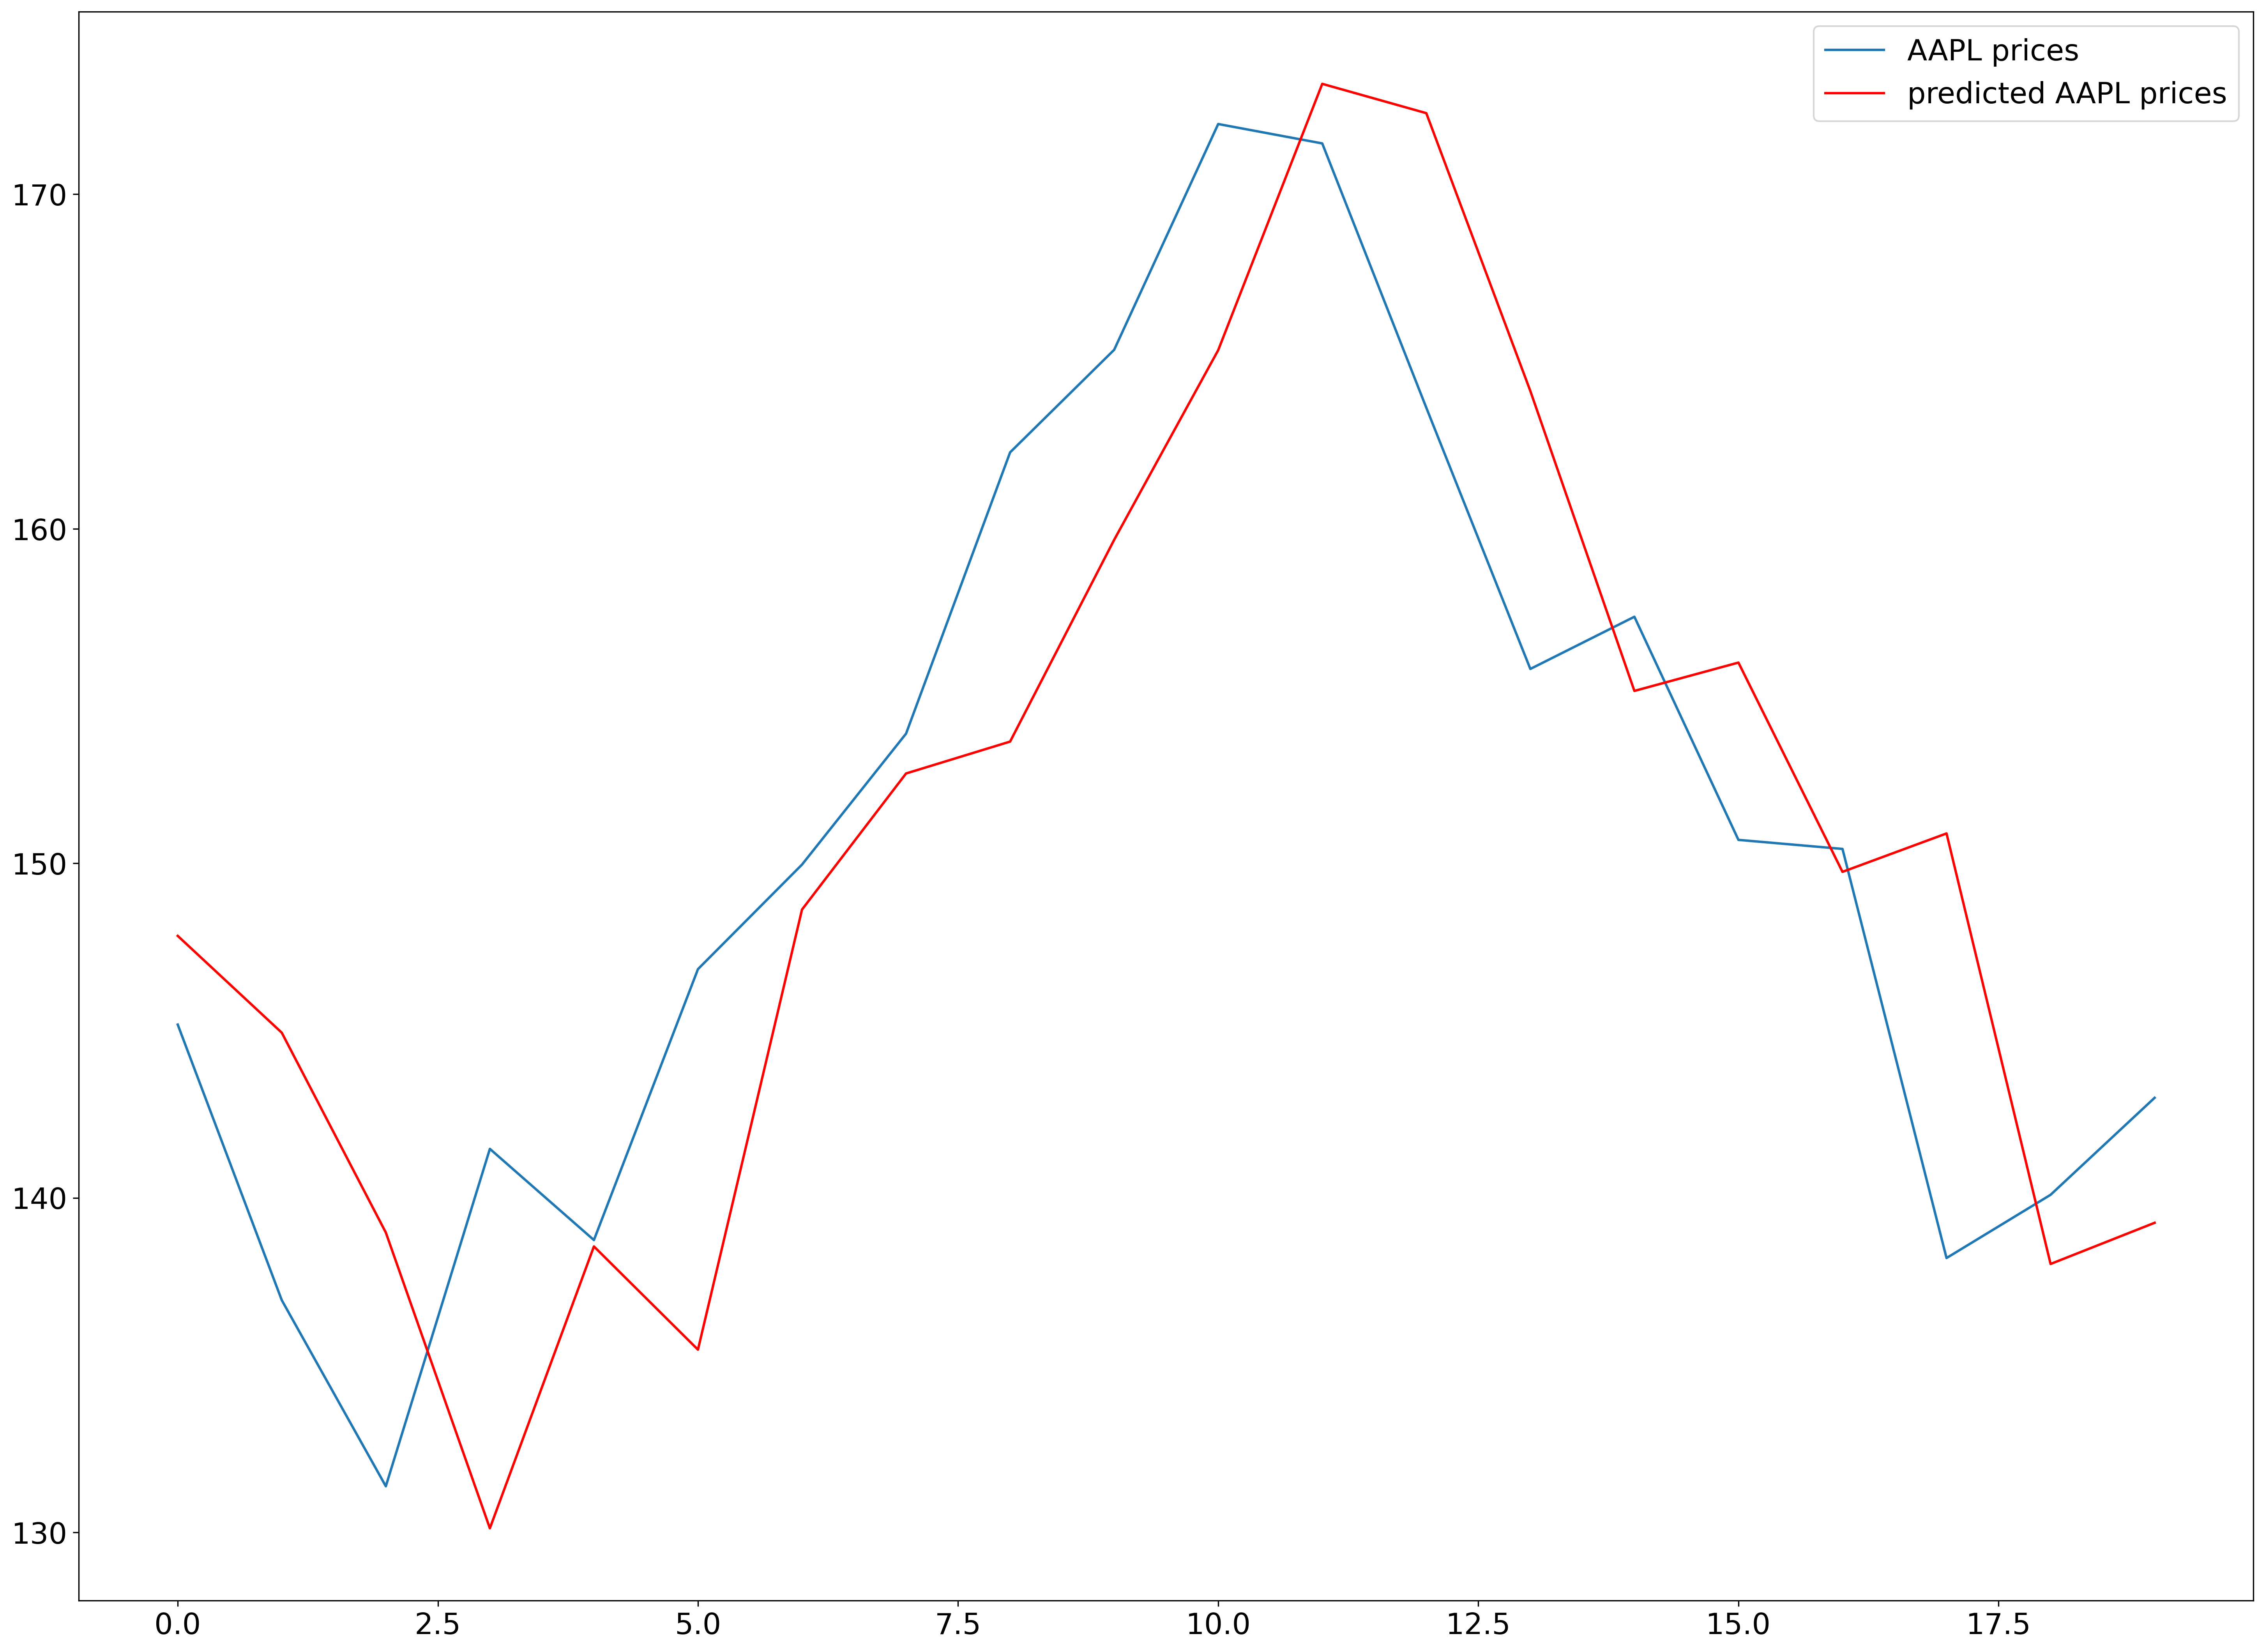

In [28]:
forecast_arima_model(X, test);

We can see our model performance as above. RMSE is 6.727 on the test data, which is higher than previous RMSE 6.306. It can mean that we could have overfit our data. Stock prediction is a hard problem in general. We used Walk-Forward validation approach to model our dataset, which allowed us to take full advantage of the data by using as much of the data as possible to fit and to test the models. However, although walk-forward is most preferred for statistical models; for ML, the improved estimate comes at the computational cost when we are creating so many models. This could be an issue at scale in case of large dataset.

#### Thanks for reading and I hope it was informative for you!

About

Last updated: 2022-10-22

Created by: Oksana Kalytenko

Twitter: [@Oxanne_k](https://twitter.com/Oxanne_k)

Medium: [Oxanne](https://medium.com/@oxannemiu)